In [31]:
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer


In [32]:
# Initialize the Binance client
api_key = 'your_api_key'
api_secret = 'your_api_secret'
client = Client(api_key, api_secret)

# Get historical data for BTCUSDT
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2010", "28 Feb, 2025")

# Create a DataFrame
df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

btc = df[['open', 'close', 'volume']].copy()
print(btc.head())

                     open          close         volume
timestamp                                              
2017-08-17  4261.48000000  4285.08000000   795.15037700
2017-08-18  4285.08000000  4108.37000000  1199.88826400
2017-08-19  4108.37000000  4139.98000000   381.30976300
2017-08-20  4120.98000000  4086.29000000   467.08302200
2017-08-21  4069.13000000  4016.00000000   691.74306000


In [33]:
for _ in range(1, 101):
    btc[f'close_{_}'] = btc['close'].shift(_)
    btc[f'volume_{_}'] = btc['volume'].shift(_)

btc['day'] = range(1, len(btc) + 1)

print(btc.head())

                     open          close         volume        close_1  \
timestamp                                                                
2017-08-17  4261.48000000  4285.08000000   795.15037700           None   
2017-08-18  4285.08000000  4108.37000000  1199.88826400  4285.08000000   
2017-08-19  4108.37000000  4139.98000000   381.30976300  4108.37000000   
2017-08-20  4120.98000000  4086.29000000   467.08302200  4139.98000000   
2017-08-21  4069.13000000  4016.00000000   691.74306000  4086.29000000   

                 volume_1        close_2       volume_2        close_3  \
timestamp                                                                
2017-08-17           None           None           None           None   
2017-08-18   795.15037700           None           None           None   
2017-08-19  1199.88826400  4285.08000000   795.15037700           None   
2017-08-20   381.30976300  4108.37000000  1199.88826400  4285.08000000   
2017-08-21   467.08302200  4139.98000

C:\Users\isaac\AppData\Local\Temp\ipykernel_5552\3470102768.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  btc[f'volume_{_}'] = btc['volume'].shift(_)
C:\Users\isaac\AppData\Local\Temp\ipykernel_5552\3470102768.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  btc[f'close_{_}'] = btc['close'].shift(_)
C:\Users\isaac\AppData\Local\Temp\ipykernel_5552\3470102768.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

In [34]:
btc_cleaned = btc.dropna()
print(btc_cleaned.head(-10))

                      open           close          volume         close_1  \
timestamp                                                                    
2017-11-25   8138.99000000   8700.01000000   4292.62368200   8138.00000000   
2017-11-26   8700.04000000   9128.02000000   4147.38023700   8700.01000000   
2017-11-27   9128.00000000   9650.00000000   4521.62570700   9128.02000000   
2017-11-28   9650.00000000   9896.80000000   4917.21098500   9650.00000000   
2017-11-29   9896.79000000   9687.88000000  13352.53871500   9896.80000000   
...                    ...             ...             ...             ...   
2025-02-14  96608.13000000  97500.48000000  18173.02646000  96608.14000000   
2025-02-15  97500.47000000  97569.66000000   7349.37683000  97500.48000000   
2025-02-16  97569.67000000  96118.12000000   8191.42490000  97569.66000000   
2025-02-17  96118.12000000  95780.00000000  16492.04510000  96118.12000000   
2025-02-18  95780.01000000  95671.74000000  23368.19471000  9578

In [35]:
# Calculate the indices for splitting the data
train_size = int(len(btc) * 0.6)
validate_size = int(len(btc) * 0.2)

# Split the data
train = btc[:train_size]
validate = btc[train_size:train_size + validate_size]
test = btc[train_size + validate_size:]

# Define the columns for train_x and train_y
x_columns = [f'close_{i}' for i in range(1, 101)] + ['day']
y_column = 'close'

# Separate train_x and train_y
train_x = train[x_columns]
train_y = train[y_column]

# Separate validate_x and validate_y
validate_x = validate[x_columns]
validate_y = validate[y_column]

# Separate test_x and test_y
test_x = test[x_columns]
test_y = test[y_column]

train_x.info()
train_y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1651 entries, 2017-08-17 to 2022-02-22
Columns: 101 entries, close_1 to day
dtypes: int64(1), object(100)
memory usage: 1.3+ MB
<class 'pandas.core.series.Series'>
DatetimeIndex: 1651 entries, 2017-08-17 to 2022-02-22
Series name: close
Non-Null Count  Dtype 
--------------  ----- 
1651 non-null   object
dtypes: object(1)
memory usage: 25.8+ KB


In [36]:
# Initialize the imputer
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform
train_x_imputed = imputer.fit_transform(train_x)
validate_x_imputed = imputer.transform(validate_x)

# Initialize the model
model = LinearRegression()

# Fit the model on the training data
model.fit(train_x_imputed, train_y)

# Predict on the training data
train_predictions = model.predict(train_x_imputed)

# Calculate the mean squared error on the training data
train_mse = mean_squared_error(train_y, train_predictions)

# Predict on the validation data
validate_predictions = model.predict(validate_x_imputed)

# Calculate the mean squared error on the validation data
validate_mse = mean_squared_error(validate_y, validate_predictions)

print(f'Training Mean Squared Error: {train_mse}')
print(f'Validation Mean Squared Error: {validate_mse}')

Training Mean Squared Error: 973228.3274622018
Validation Mean Squared Error: 840962.5655124666


C:\Users\isaac\AppData\Local\Temp\ipykernel_5552\3241829660.py:8: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(train.index, train_predictions, label='Predicted Close Price', linestyle='--')


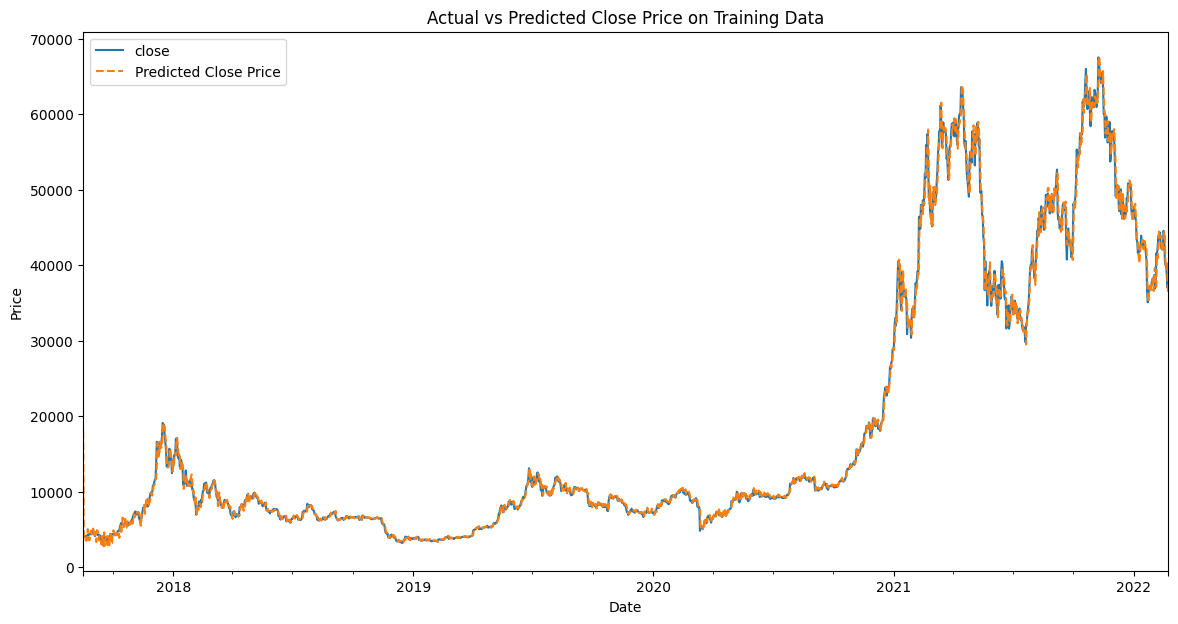

C:\Users\isaac\AppData\Local\Temp\ipykernel_5552\3241829660.py:21: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(validate.index, validate_predictions, label='Predicted Close Price', linestyle='--')


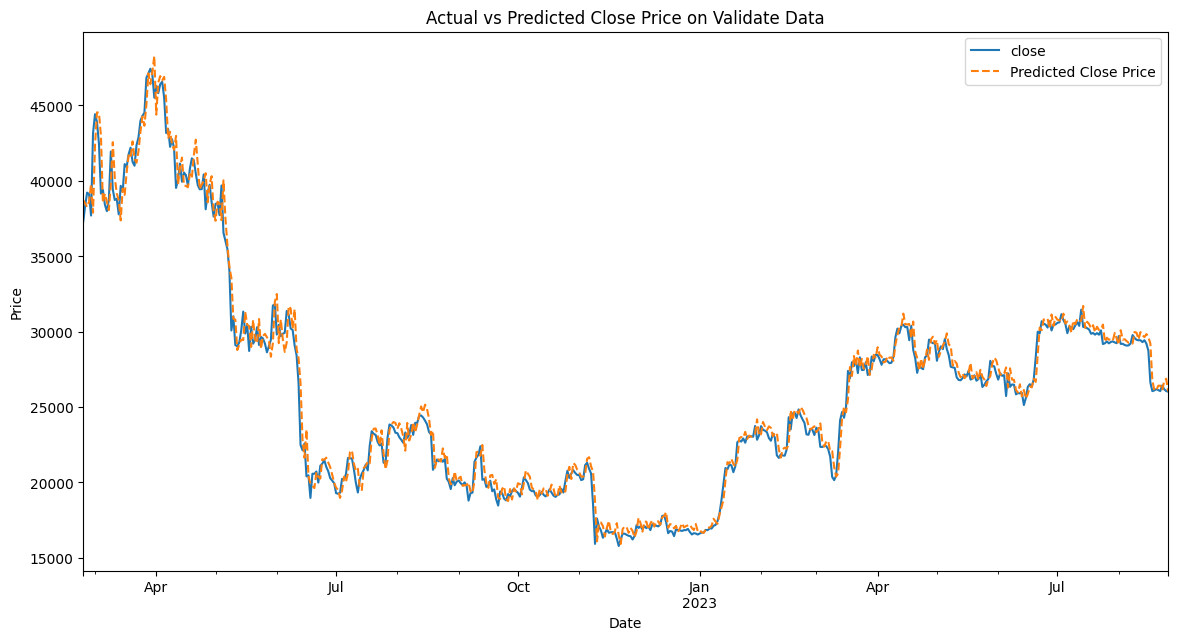

In [37]:
# Predict on the training data
train_predictions = model.predict(train_x_imputed)

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
train_y = pd.to_numeric(train_y)
train_y.plot(figsize=(14, 7), title='Train Y - Actual Close Prices')
plt.plot(train.index, train_predictions, label='Predicted Close Price', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Training Data')
plt.legend()
plt.show()

# Predict on the validate data
validate_predictions = model.predict(validate_x_imputed)

plt.figure(figsize=(14, 7))
validate_y = pd.to_numeric(validate_y)
validate_y.plot(figsize=(14, 7))
plt.plot(validate.index, validate_predictions, label='Predicted Close Price', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Validate Data')
plt.legend()
plt.show()